STOCK PRICE PREDICTION - NEURAL NETWORK VS LOGISTIC REGRESSION

[1/15] Downloading AAPL data from 2020-01-01 to 2024-01-01...
Downloaded 1006 days of data

[2/15] Creating technical indicators...
After feature engineering: 993 samples

[3/15] Creating sliding window dataset (window=7 days)...
Dataset shape: X=(986, 28), y=(986,)
Number of features per sample: 28
Class distribution: UP=517, DOWN=469

[4/15] Splitting data (70% train, 15% val, 15% test)...
Train: 690 samples
Validation: 147 samples
Test: 149 samples

[5/15] Scaling features...

[6/15] Building neural network...
Model has 3,969 parameters

[7/15] Training neural network...
Training stopped at epoch 7

[8/15] Training logistic regression baseline...

[9/15] Making predictions on test set...

[10/15] Evaluating models...

Neural Network Results
Accuracy:  0.4430
Precision: 0.5000
Recall:    0.0241
F1-Score:  0.0460
ROC-AUC:   0.5365

Logistic Regression Results
Accuracy:  0.4564
Precision: 0.5227
Recall:    0.2771
F1-Score:


Saved: model_comparison.png

[15/17] Saving models...
Saved: model.h5
Saved: scaler.pkl
Saved: logistic_regression.pkl

[16/17] Creating detailed predictions table...
Saved: predictions_details.csv

LAST 20 PREDICTIONS (Most Recent)
      Date Actual_Direction NN_Prediction NN_Confidence LR_Prediction LR_Confidence NN_Correct LR_Correct
2023-12-01               UP          DOWN        35.71%          DOWN        47.78%          ✗          ✗
2023-12-04             DOWN          DOWN        36.84%          DOWN        44.44%          ✓          ✓
2023-12-05               UP          DOWN        37.51%            UP        53.63%          ✗          ✓
2023-12-06             DOWN          DOWN        32.42%          DOWN        37.67%          ✓          ✓
2023-12-07               UP          DOWN        38.62%          DOWN        47.53%          ✗          ✗
2023-12-08               UP          DOWN        35.41%          DOWN        49.01%          ✗          ✗
2023-12-11             D

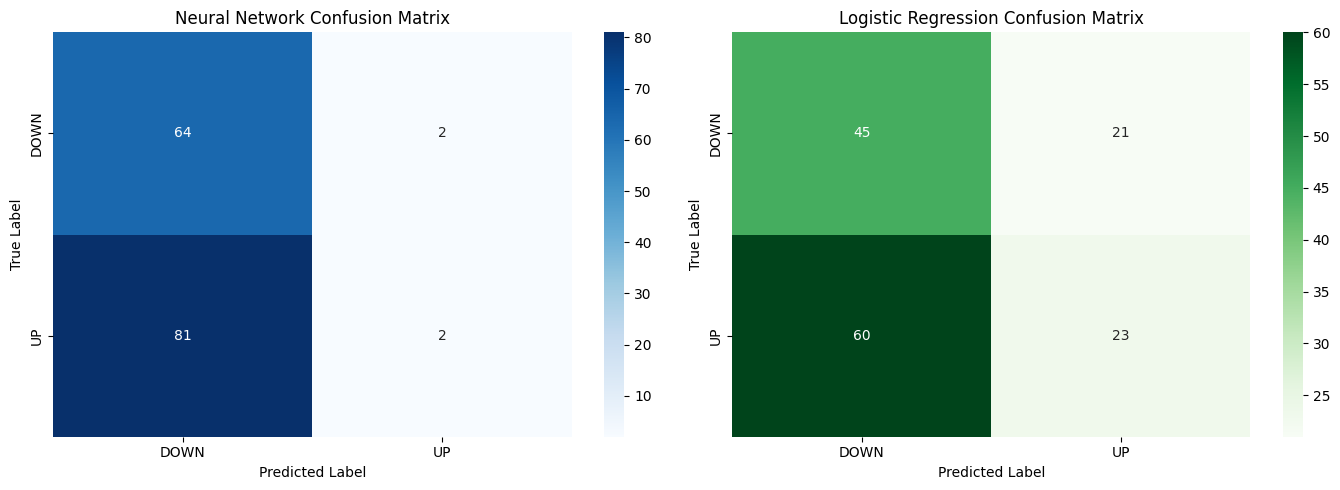

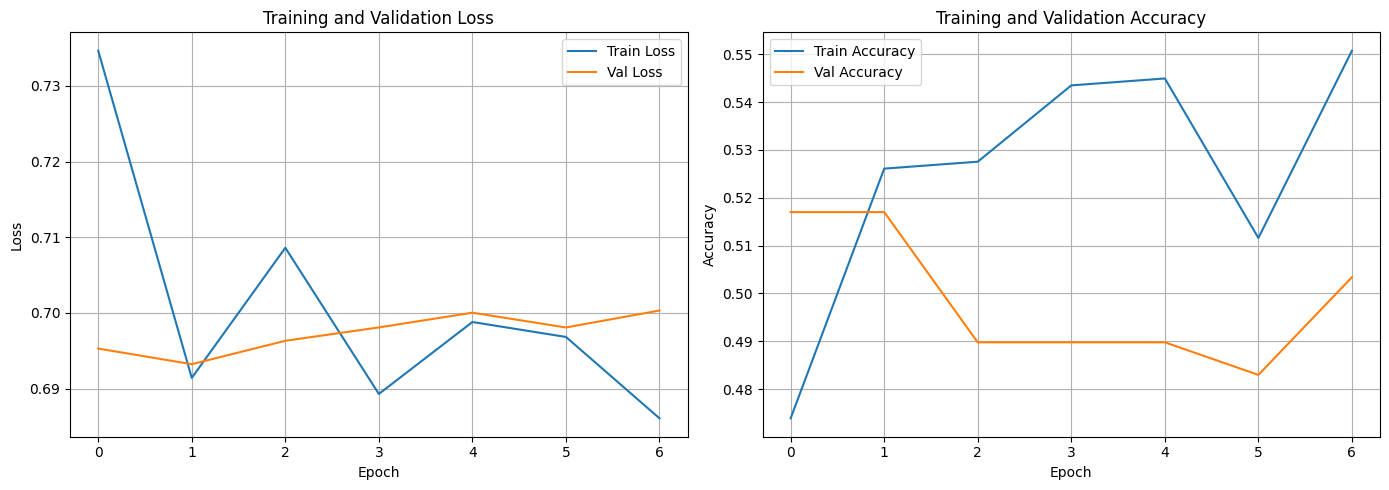

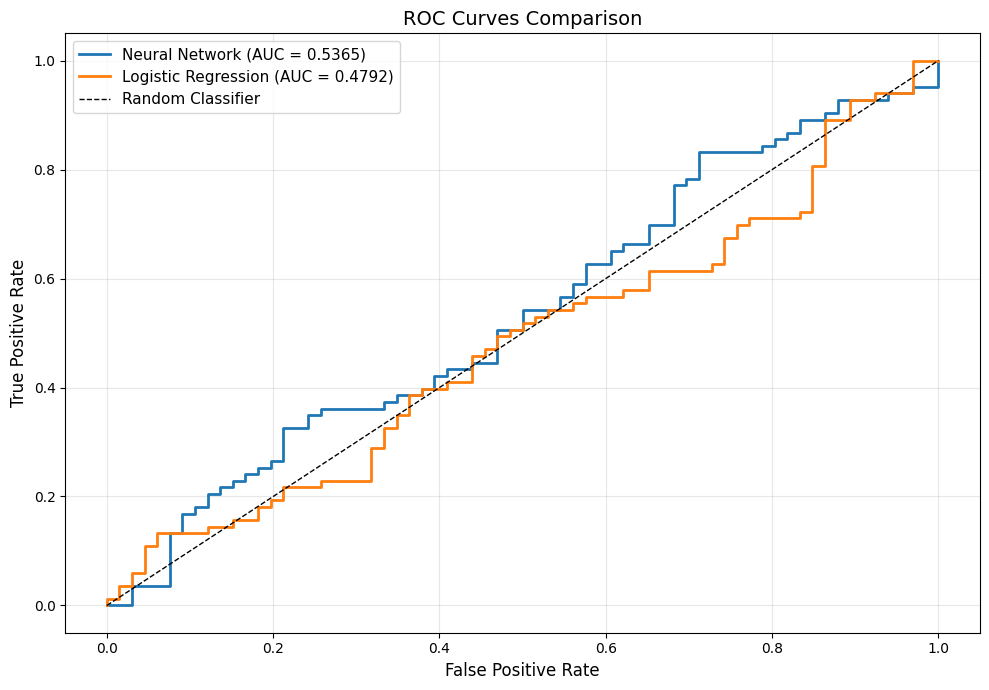

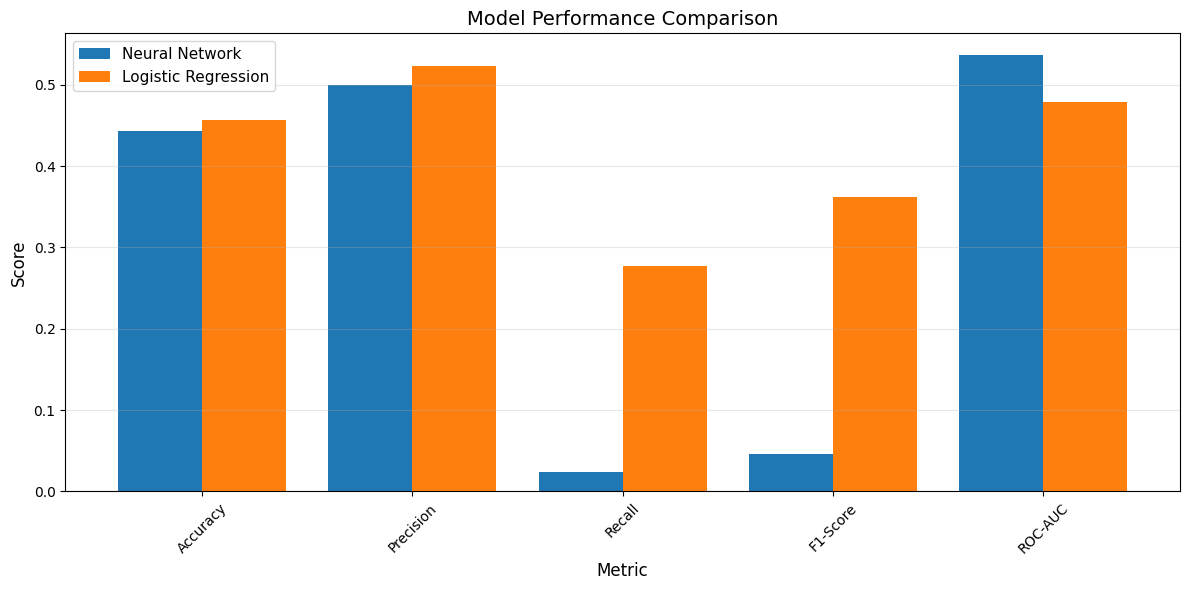

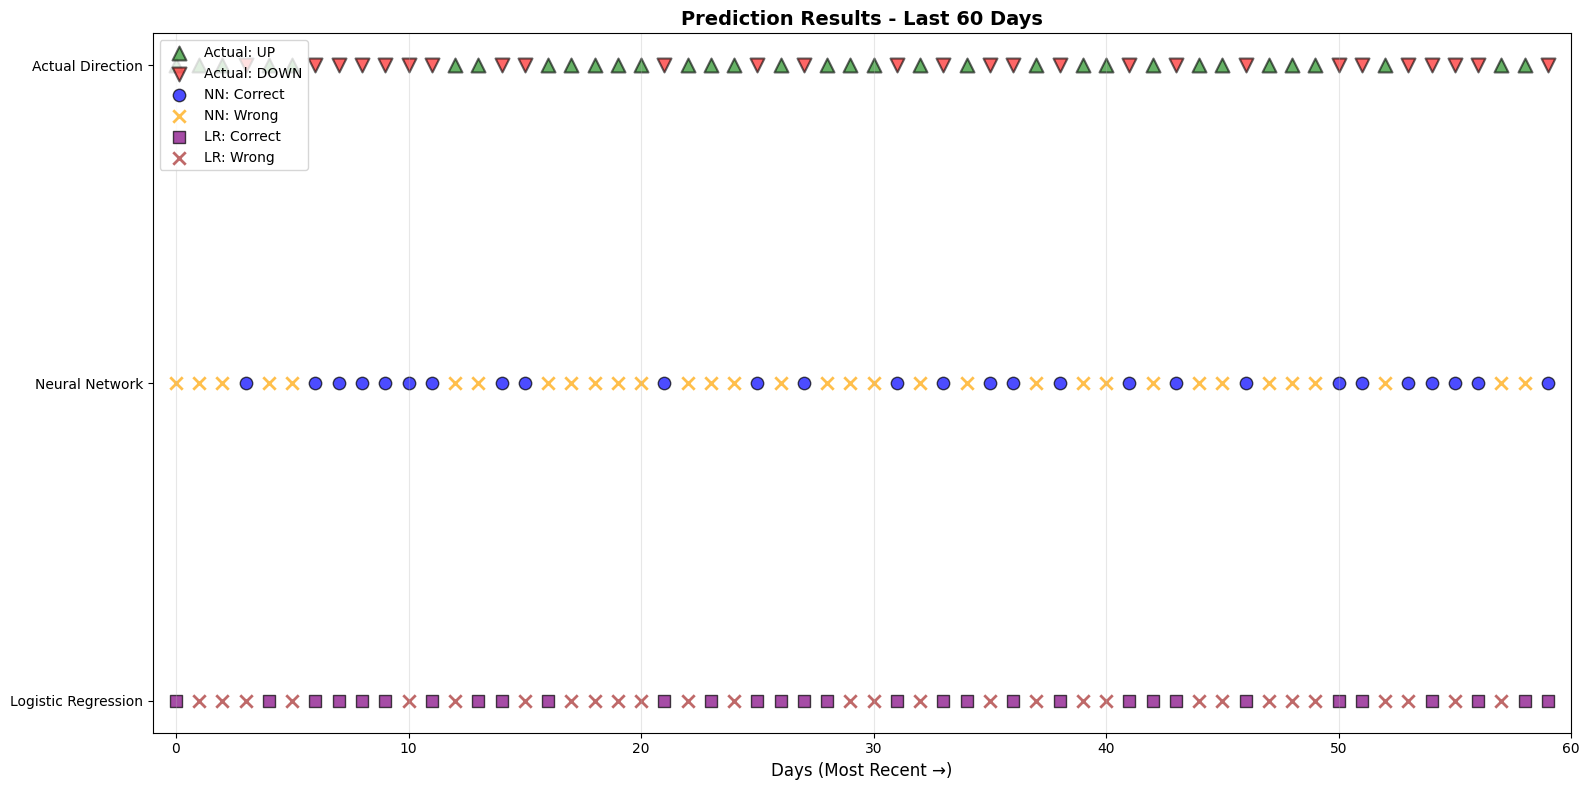

In [3]:
"""
Stock Price Direction Prediction
Goal: Predict if a stock will go UP (1) or DOWN (0) tomorrow using:
- A simple feedforward neural network
- Logistic regression (baseline)
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix, roc_curve)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. PARAMETERS
# ============================================================================
TICKER = 'AAPL'  # Change to any stock ticker
START_DATE = '2020-01-01'
END_DATE = '2024-01-01'
WINDOW = 7  # Use past 7 days for features

print("="*60)
print("STOCK PRICE PREDICTION - NEURAL NETWORK VS LOGISTIC REGRESSION")
print("="*60)

# ============================================================================
# 2. DOWNLOAD STOCK DATA
# ============================================================================
print(f"\n[1/15] Downloading {TICKER} data from {START_DATE} to {END_DATE}...")
df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
print(f"Downloaded {len(df)} days of data")

# ============================================================================
# 3. FEATURE ENGINEERING
# ============================================================================
print("\n[2/15] Creating technical indicators...")

# Calculate daily returns
df['Return'] = df['Close'].pct_change()

# Calculate moving averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()

# Calculate RSI (14-day)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df['Close'])

# Create label: 1 if tomorrow's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop rows with NaN values
df = df.dropna()
print(f"After feature engineering: {len(df)} samples")

# ============================================================================
# 4. CREATE SLIDING WINDOW DATASET
# ============================================================================
print(f"\n[3/15] Creating sliding window dataset (window={WINDOW} days)...")

feature_cols = ['Return', 'MA5', 'MA10', 'RSI']

X = []
y = []

for i in range(WINDOW, len(df)):
    # Get past WINDOW days of features
    window_features = df[feature_cols].iloc[i-WINDOW:i].values.flatten()
    X.append(window_features)
    # Get target (already shifted, so it's the next day's direction)
    y.append(df['Target'].iloc[i-1])

X = np.array(X)
y = np.array(y)

print(f"Dataset shape: X={X.shape}, y={y.shape}")
print(f"Number of features per sample: {X.shape[1]}")
print(f"Class distribution: UP={np.sum(y==1)}, DOWN={np.sum(y==0)}")

# ============================================================================
# 5. TRAIN/VALIDATION/TEST SPLIT
# ============================================================================
print("\n[4/15] Splitting data (70% train, 15% val, 15% test)...")

n = len(X)
train_size = int(0.7 * n)
val_size = int(0.15 * n)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"Train: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

# ============================================================================
# 6. FEATURE SCALING
# ============================================================================
print("\n[5/15] Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ============================================================================
# 7. BUILD NEURAL NETWORK
# ============================================================================
print("\n[6/15] Building neural network...")

np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(f"Model has {model.count_params():,} parameters")

# ============================================================================
# 8. TRAIN NEURAL NETWORK
# ============================================================================
print("\n[7/15] Training neural network...")

early_stop = EarlyStopping(monitor='val_loss', patience=5,
                          restore_best_weights=True, verbose=0)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

print(f"Training stopped at epoch {len(history.history['loss'])}")

# ============================================================================
# 9. TRAIN LOGISTIC REGRESSION
# ============================================================================
print("\n[8/15] Training logistic regression baseline...")

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# ============================================================================
# 10. MAKE PREDICTIONS
# ============================================================================
print("\n[9/15] Making predictions on test set...")

# Neural Network predictions
y_pred_nn_prob = model.predict(X_test_scaled, verbose=0).flatten()
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int)

# Logistic Regression predictions
y_pred_lr_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = log_reg.predict(X_test_scaled)

# ============================================================================
# 11. EVALUATE MODELS
# ============================================================================
print("\n[10/15] Evaluating models...")

def evaluate_model(y_true, y_pred, y_pred_prob, model_name):
    print(f"\n{'='*60}")
    print(f"{model_name} Results")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_true, y_pred_prob):.4f}")

    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred_prob)
    }

nn_metrics = evaluate_model(y_test, y_pred_nn, y_pred_nn_prob, "Neural Network")
lr_metrics = evaluate_model(y_test, y_pred_lr, y_pred_lr_prob, "Logistic Regression")

# ============================================================================
# 12. PLOT CONFUSION MATRICES
# ============================================================================
print("\n[11/15] Creating confusion matrices...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Neural Network confusion matrix
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Neural Network Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_xticklabels(['DOWN', 'UP'])
axes[0].set_yticklabels(['DOWN', 'UP'])

# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_xticklabels(['DOWN', 'UP'])
axes[1].set_yticklabels(['DOWN', 'UP'])

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("Saved: confusion_matrices.png")

# ============================================================================
# 13. PLOT TRAINING HISTORY
# ============================================================================
print("\n[12/15] Creating training history plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("Saved: training_history.png")

# ============================================================================
# 14. PLOT ROC CURVES
# ============================================================================
print("\n[13/15] Creating ROC curves comparison...")

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_prob)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr_prob)

plt.figure(figsize=(10, 7))
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_metrics["roc_auc"]:.4f})', linewidth=2)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_metrics["roc_auc"]:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
print("Saved: roc_curves.png")

# ============================================================================
# 15. COMPARISON SUMMARY
# ============================================================================
print("\n[14/15] Creating comparison summary...")

comparison = pd.DataFrame({
    'Neural Network': [nn_metrics['accuracy'], nn_metrics['precision'],
                       nn_metrics['recall'], nn_metrics['f1'], nn_metrics['roc_auc']],
    'Logistic Regression': [lr_metrics['accuracy'], lr_metrics['precision'],
                            lr_metrics['recall'], lr_metrics['f1'], lr_metrics['roc_auc']]
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison.round(4))
print("="*60)

# Visualize comparison
comparison.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Model Performance Comparison', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\nSaved: model_comparison.png")

# ============================================================================
# 16. SAVE MODELS
# ============================================================================
print("\n[15/17] Saving models...")

model.save('model.h5')
print("Saved: model.h5")

joblib.dump(scaler, 'scaler.pkl')
print("Saved: scaler.pkl")

joblib.dump(log_reg, 'logistic_regression.pkl')
print("Saved: logistic_regression.pkl")

# ============================================================================
# 17. DETAILED PREDICTIONS TABLE
# ============================================================================
print("\n[16/17] Creating detailed predictions table...")

# Get the dates for test set
test_dates = df.index[train_size+val_size+WINDOW:]

# Create predictions DataFrame
predictions_df = pd.DataFrame({
    'Date': test_dates[:len(y_test)],
    'Actual_Direction': ['UP' if y == 1 else 'DOWN' for y in y_test],
    'NN_Prediction': ['UP' if y == 1 else 'DOWN' for y in y_pred_nn],
    'NN_Confidence': [f"{prob:.2%}" for prob in y_pred_nn_prob],
    'LR_Prediction': ['UP' if y == 1 else 'DOWN' for y in y_pred_lr],
    'LR_Confidence': [f"{prob:.2%}" for prob in y_pred_lr_prob],
    'NN_Correct': ['✓' if y_test[i] == y_pred_nn[i] else '✗' for i in range(len(y_test))],
    'LR_Correct': ['✓' if y_test[i] == y_pred_lr[i] else '✗' for i in range(len(y_test))]
})

# Save to CSV
predictions_df.to_csv('predictions_details.csv', index=False)
print("Saved: predictions_details.csv")

# Display last 20 predictions
print("\n" + "="*100)
print("LAST 20 PREDICTIONS (Most Recent)")
print("="*100)
print(predictions_df.tail(20).to_string(index=False))
print("="*100)

# ============================================================================
# 18. PREDICTION VISUALIZATION
# ============================================================================
print("\n[17/17] Creating prediction visualization...")

# Plot last 60 days of predictions
plot_days = min(60, len(predictions_df))
plot_df = predictions_df.tail(plot_days).copy()
plot_df['Index'] = range(len(plot_df))

fig, ax = plt.subplots(figsize=(16, 8))

# Plot actual direction
actual_up = plot_df[plot_df['Actual_Direction'] == 'UP']
actual_down = plot_df[plot_df['Actual_Direction'] == 'DOWN']

ax.scatter(actual_up['Index'], [1]*len(actual_up), color='green', s=100,
           marker='^', label='Actual: UP', alpha=0.6, edgecolors='black', linewidth=1.5)
ax.scatter(actual_down['Index'], [1]*len(actual_down), color='red', s=100,
           marker='v', label='Actual: DOWN', alpha=0.6, edgecolors='black', linewidth=1.5)

# Plot NN predictions
nn_correct = plot_df[plot_df['NN_Correct'] == '✓']
nn_wrong = plot_df[plot_df['NN_Correct'] == '✗']

ax.scatter(nn_correct['Index'], [0.5]*len(nn_correct), color='blue', s=80,
           marker='o', label='NN: Correct', alpha=0.7, edgecolors='black', linewidth=1)
ax.scatter(nn_wrong['Index'], [0.5]*len(nn_wrong), color='orange', s=80,
           marker='x', label='NN: Wrong', alpha=0.7, linewidth=2)

# Plot LR predictions
lr_correct = plot_df[plot_df['LR_Correct'] == '✓']
lr_wrong = plot_df[plot_df['LR_Correct'] == '✗']

ax.scatter(lr_correct['Index'], [0]*len(lr_correct), color='purple', s=80,
           marker='s', label='LR: Correct', alpha=0.7, edgecolors='black', linewidth=1)
ax.scatter(lr_wrong['Index'], [0]*len(lr_wrong), color='brown', s=80,
           marker='x', label='LR: Wrong', alpha=0.7, linewidth=2)

# Formatting
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['Logistic Regression', 'Neural Network', 'Actual Direction'])
ax.set_xlabel('Days (Most Recent →)', fontsize=12)
ax.set_title(f'Prediction Results - Last {plot_days} Days', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim(-1, len(plot_df))

plt.tight_layout()
plt.savefig('predictions_visualization.png', dpi=300, bbox_inches='tight')
print("Saved: predictions_visualization.png")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*100)
print("PREDICTION COMPLETE!")
print("="*100)
print(f"\nStock: {TICKER}")
print(f"Period: {START_DATE} to {END_DATE}")
print(f"Test samples: {len(y_test)}")

# Summary statistics
nn_correct_count = (y_test == y_pred_nn).sum()
lr_correct_count = (y_test == y_pred_lr).sum()

print(f"\nNeural Network: {nn_correct_count}/{len(y_test)} correct predictions ({nn_correct_count/len(y_test)*100:.1f}%)")
print(f"Logistic Regression: {lr_correct_count}/{len(y_test)} correct predictions ({lr_correct_count/len(y_test)*100:.1f}%)")

print(f"\nBest Model: ", end="")
if nn_metrics['roc_auc'] > lr_metrics['roc_auc']:
    print(f"Neural Network (ROC-AUC: {nn_metrics['roc_auc']:.4f})")
else:
    print(f"Logistic Regression (ROC-AUC: {lr_metrics['roc_auc']:.4f})")

# Show prediction breakdown
print(f"\n{'='*100}")
print("PREDICTION BREAKDOWN")
print(f"{'='*100}")

nn_up_pred = (y_pred_nn == 1).sum()
nn_down_pred = (y_pred_nn == 0).sum()
lr_up_pred = (y_pred_lr == 1).sum()
lr_down_pred = (y_pred_lr == 0).sum()
actual_up = (y_test == 1).sum()
actual_down = (y_test == 0).sum()

print(f"\nActual:              UP: {actual_up:3d} ({actual_up/len(y_test)*100:5.1f}%)  |  DOWN: {actual_down:3d} ({actual_down/len(y_test)*100:5.1f}%)")
print(f"Neural Network:      UP: {nn_up_pred:3d} ({nn_up_pred/len(y_test)*100:5.1f}%)  |  DOWN: {nn_down_pred:3d} ({nn_down_pred/len(y_test)*100:5.1f}%)")
print(f"Logistic Regression: UP: {lr_up_pred:3d} ({lr_up_pred/len(y_test)*100:5.1f}%)  |  DOWN: {lr_down_pred:3d} ({lr_down_pred/len(y_test)*100:5.1f}%)")

print("\nGenerated files:")
print("  - model.h5")
print("  - scaler.pkl")
print("  - logistic_regression.pkl")
print("  - predictions_details.csv")
print("  - confusion_matrices.png")
print("  - training_history.png")
print("  - roc_curves.png")
print("  - model_comparison.png")
print("  - predictions_visualization.png")
print("\n" + "="*100)